<a href="https://colab.research.google.com/github/nayaganindia/ramesh/blob/main/Week4AssignmentFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of Neighborhoods - Locate ideal neighbourhood

# Business Problem

In this modern age, Canada is a very popular immigration destination. Lots of people are migrating to various states of Canada and needed lots of information on good housing prices and reputated schools for their children. 

This scope of this Project is to help indians migrating to Toronto to identify a best neighborhood as a comparative analysis between neighborhoods. 

The features used in analysis will be to identify neghbourhoods where following facilities are mostly available nearby like school, shops, transport facilities, indian restaurants, medical facilities etc

Thus our business problem to solve is, which neighborhood is ideal to move in for a indian immigrant. 



# Approach
This project will utilize publicly available data from Wikipedia and Foursquare.

Specifically, all Toronto neighborhood details along with their postal codes are available here: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

The focus of this project will be to acquire data by using web scraping method of python and then clean the data,populate the data then use foursquare API to collect the data of the all the neighborhood places then use k-means clustering method to find the best fit.


# Solution





## 1. Data

Get the data from wiki portal - https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and prepare it.

Get the location coordinates from - https://cocl.us/Geospatial_data

Merge both the data to arrive at our source of data.

Following data sources will be needed to extract/generate the required information:

- Group the neighbourhoods based on postal code and use K-means clustering to analyse and visualize the data.
- Location details like latitude and longitude details are fetched from remote location, alternatively they can also be retrieved from Google Maps API. 

- Fetch the facilities like Restaurants, Bus Stations, Schools, Coffee shops, Grocery Shops etc in every neighborhood using Foursquare API
- Identify the neighbourhood which matches our requirement - having most of preferred facilities, and recommend it to the customer.


In [ ]:
# import required modules

import pandas as pd
import numpy as np


In [ ]:
# fetch data from wiki 
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.describe()

,Postal Code,Borough,Neighbourhood
count,180,180,180
unique,180,11,100
top,M4P,Not assigned,Not assigned
freq,1,77,77


In [ ]:
# clean data
# clean dataframe 
df = df[df.Borough!='Not assigned']
df = df[df.Borough!= 0]
df.reset_index(drop = True, inplace = True)

df = df.groupby(['Postal Code','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.describe()

,Postal Code,Borough,Neighbourhood
count,103,103,103
unique,103,10,99
top,M4P,North York,Downsview
freq,1,24,4


In [ ]:
# Get longitude and lattitude data
dfLatLon = pd.read_csv('https://cocl.us/Geospatial_data')
dfLatLon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [ ]:
#merge the data sets
df = pd.merge(df,dfLatLon,on=df['Postal Code'])
df.head()

,key_0,Postal Code_x,Borough,Neighbourhood,Postal Code_y,Latitude,Longitude
0,M1B,M1B,Scarborough,"Malvern, Rouge",M1B,43.806686,-79.194353
1,M1C,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",M1C,43.784535,-79.160497
2,M1E,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [ ]:
# for convenience we will retain only one Postal Code column - clean up
df.drop(columns=['key_0'],inplace=True)
df.drop(columns=['Postal Code_y'],inplace=True)
df.rename(columns={"Postal Code_x":"Postal Code"},inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [ ]:
#save data to file
df.to_csv('toronto.csv', index=False)


# 2. Process data

# 3. Map the Neighbourhoods


In [ ]:
# Pre-requisites
!pip install geopy
!pip install folium

In [ ]:
# Import the modules

import folium
import requests 
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [ ]:
# Read our Data
df = pd.read_csv('toronto.csv')
print(df.shape)
df.head(20)


(103, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Map Toronto


In [ ]:
# Pick toronto area
latitude = df[df['Postal Code'] == 'M5G'].Latitude.values
longitude = df[df['Postal Code'] == 'M5G'].Longitude.values
print(latitude)
print(longitude)

map_toronto = folium.Map(location=[latitude,longitude], zoom_start=10)
#map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)
map_toronto


[43.6579524]
[-79.3873826]


In [ ]:
# capture the neighbourhood

map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df['Latitude'],df['Longitude'],df['Borough'],df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

# 4. Foursquare API to explore neighborhoods
## We will fetch the venue names, locations, menus photos etc. and all the information about the prices and school near 100 meters of radius, for our analysis.


In [ ]:
# Foursquare API
CLIENT_ID = 'RWNQW4FG2TUQFLTSH4DKP0N5ZOPT2LEFN42RUQATS3W5PX2A' # Put Your Client Id
CLIENT_SECRET = 'BXS5QIXDX1BUJMDADMGRATZTHO22BKCXDQJREB15NV011D3Q' # Put You Client Secret 
VERSION = '20201122'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: Hidden')
print('CLIENT_SECRET: Hidden')


Your credentails:
CLIENT_ID: Hidden
CLIENT_SECRET: Hidden


In [ ]:
# Getting Near By Venus, Schools and locations Category
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([( name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)


In [ ]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'], latitudes=df['Latitude'],longitudes=df['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [ ]:
print(toronto_venues.shape)
toronto_venues.head()

(1338, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [ ]:
# List of Categories
toronto_venues['Venue Category']

0                Fast Food Restaurant
1                                 Bar
2          Construction & Landscaping
3                                Bank
4                   Electronics Store
5                          Restaurant
6                  Mexican Restaurant
7                 Rental Car Location
8                      Medical Center
9                        Intersection
10                     Breakfast Spot
11                        Coffee Shop
12                        Coffee Shop
13              Korean BBQ Restaurant
14                 Mexican Restaurant
15                   Hakka Restaurant
16               Caribbean Restaurant
17                    Thai Restaurant
18                 Athletics & Sports
19                               Bank
20                        Gas Station
21                             Bakery
22                Fried Chicken Joint
23                         Playground
24                      Jewelry Store
25                         Smoke Shop
26          

In [ ]:
# we are interested in finding a location which has nice restaurants, school, park, grocery store 


## 3  We are interested in a neighbourhood which has the atleast one or more of the below type of business : 
Bank,
Medical Center,
Gas Station,
Bakery,
Department Store,
Train Station,
Bus Line,
Metro Station,
Bus Station,
Bus Line,
Indian Restaurant,
Shopping Mall,
Pharmacy,
Convenience Store,
Supermarket,
Fruit & Vegetable Store,
Farmers Market.



In [ ]:
# filter for locations where venue category match our list above
fav_cat = ['Bank', 'Medical Center', 'Gas Station', 'Bakery', 'Department Store', 'Train Station', 'Bus Line', 'Metro Station', 'Bus Station', 'Bus Line', 'Indian Restaurant', 'Shopping Mall', 'Pharmacy', 'Convenience Store', 'Supermarket', 'Fruit & Vegetable Store', 'Farmers Market']
tor_fav_venues = toronto_venues[toronto_venues['Venue Category'].isin(fav_cat)]
tor_fav_venues.shape

print("Venues which match our criteria = ",tor_fav_venues.shape[0])


Venues which match our criteria =  132


In [ ]:
tor_fav_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
8,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
19,Cedarbrae,43.773136,-79.239476,TD Canada Trust,43.774830,-79.241251,Bank
20,Cedarbrae,43.773136,-79.239476,Petro-Canada,43.774106,-79.243097,Gas Station
21,Cedarbrae,43.773136,-79.239476,B&A Bakery,43.774391,-79.243877,Bakery


In [ ]:
# lets visualize them on a map
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13)

for lat, lng, label in zip(tor_fav_venues['Venue Latitude'], tor_fav_venues['Venue Longitude'], tor_fav_venues['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [ ]:
# We will pick up which neighbourhood has the most number of matches (categories)
dfPlot = tor_fav_venues.groupby('Neighbourhood').count()  
df= dfPlot.drop(columns=['Neighbourhood Latitude','Neighbourhood Longitude','Venue','Venue Latitude','Venue Longitude'])
df.head()


,Venue Category
Neighbourhood,
"Alderwood, Long Branch",1
"Bathurst Manor, Wilson Heights, Downsview North",6
Bayview Village,1
"Bedford Park, Lawrence Manor East",2
Berczy Park,3


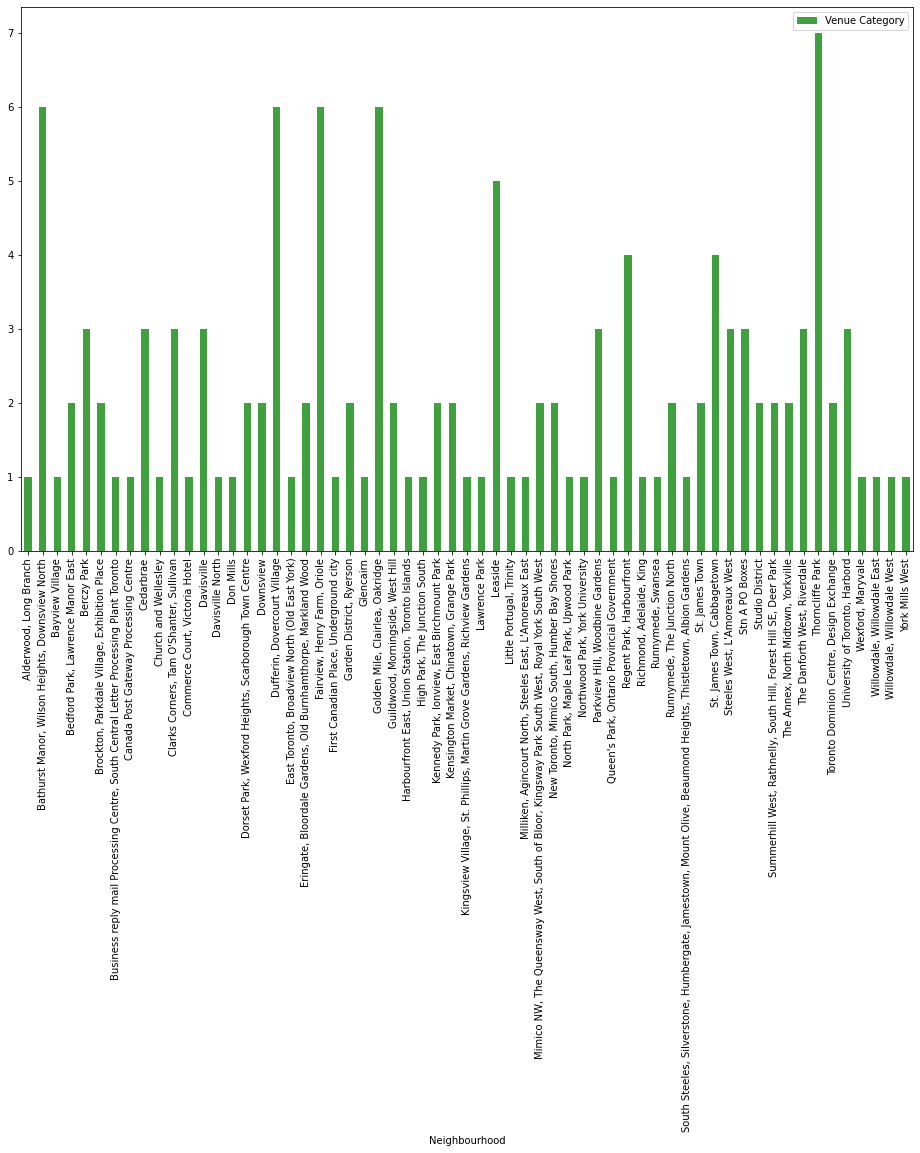

In [ ]:
df.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

In [ ]:
# pick the area which has the maximum number of preferred facitlities (categories)
dfRes = df[df['Venue Category'] == df['Venue Category'].max()]
dfRes.head()

,Venue Category
Neighbourhood,
Thorncliffe Park,7


# Conclusion

Finally, by leveraging the FourSquare API and K-Means clustering, we are able to pick a neighbourhood which can be recommended for Indian Immigrants to Toronto. 

